<a href="https://colab.research.google.com/github/vtecftwy/metagenomics/blob/refactor_cnn_virus/nbs/2_01_EC_test_cnn_virus_code_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First experiments with CNN_Virus code

The original code for CNN-Virus is in the github repo [here](https://github.com/MaHaoran627/CNN_Virus).

This notebook uses the refactored model architecture and a few functions from the original CNN_Virus code.
- Refactored code is in `metagentools.cnn_virus.architecture`

> This notebook assumes you have access to the `Metagenomics` gdrive shared folder, right under the grdive root. You should add a shortcut to the shared directory at the top of you gdrive.

In [40]:
import numpy as np
import os
import sys
from pathlib import Path
from ecutilities.ipython import nb_setup
from metagentools.core import ProjectFileSystem
from metagentools.cnn_virus.architecture import create_model_original
from tensorflow.keras.utils import Sequence, to_categorical

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {'0', '1', '2'}

# Setup the notebook for development
nb_setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


Retrieve the paths to key project directories, and setup environment if running on Colab

In [ ]:
pfs = ProjectFileSystem()

# Install the required packages if running on colab
if pfs.is_colab:
    !pip install -Uqq metagentools
    !pip install -Uqq ecutilities 

data = pfs.data
assert data.is_dir()

# Preprocessing data

In [43]:
# path for the training file
filepath_train= data /"CNN_Virus_data/50mer_training"
assert filepath_train.is_file()
# path for the validating file
filepath_val= data / "CNN_Virus_data/50mer_validating"
assert filepath_val.is_file()
# path for the learning weights file
filepath_weights=data / "CNN_Virus_data/weight_of_classes"
assert filepath_weights.is_file()

### Original code
Functions from the original code that we need in this notebook

In [44]:
def get_params_50mer():
    """set default params for generating batches of 50-mer"""
    params = {'batch_size': 1024,
    'n_classes': 187,
    'shuffle': True}
    return params

In [45]:
def get_learning_weights(filepath):
    f = open(filepath,"r").readlines()
    d_weights = {}
    for i in f:
        i = i.strip().split("\t")
        d_weights[float(i[0])]=float(i[1])
    return d_weights

In [46]:
def get_kmer_from_50mer(filepath, max_seqs=None):
    """Load data from sequence file and returns three tensors, with max nbr sequences"""
    f_matrix=[]
    f_labels=[]
    f_pos=[]
    with open(filepath, 'r') as fp:
        i = 0
        while True:
            line = fp.readline()
            i += 1
            # EOF
            if line == '':
                break
            # Reached max number of k-mers to load from file
            elif max_seqs is not None and i > max_seqs:
                break
            else:
                seq, label, pos = line.strip().split('\t')
                f_matrix.append(seq)
                f_labels.append(label)
                f_pos.append(pos)
    return f_matrix,f_labels,f_pos

In [47]:
class DataGenerator_from_50mer(Sequence):
    """data generator for generating batches of data from 50-mers"""
    def __init__(self, f_matrix, f_labels, f_pos, batch_size=1024,n_classes=187, shuffle=True):
        self.batch_size = batch_size
        self.labels = f_labels
        self.matrix = f_matrix
        self.pos = f_pos
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y= self.__data_generation(indexes)
        return X,y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, index):
        x_train=[]
        for i in index:
            seq=self.matrix[i]
            seq_list=[j for j in seq]
            x_train.append(seq_list)
        x_train=np.array(x_train)
        x_tensor=np.zeros(list(x_train.shape)+[5])
        for row in range(len(x_train)):
            for col in range(50):
                x_tensor[row,col,d_nucl[x_train[row,col]]]=1
        y_pos=[]
        y_label=[self.labels[i] for i in index]
        y_label=np.array(y_label)
        y_label=to_categorical(y_label, num_classes=self.n_classes)
        y_pos=[self.pos[i] for i in index]
        y_pos=np.array(y_pos)
        y_pos=to_categorical(y_pos, num_classes=10)
        return x_tensor,{'output1': y_label, 'output2': y_pos}

In [48]:
f_matrix, f_labels, f_pos = get_kmer_from_50mer(filepath_train, max_seqs=100_000)
len(f_matrix), len(f_labels), len(f_pos)

(100000, 100000, 100000)

In [49]:
i = 0
f_matrix[i], f_labels[i], f_pos[i]

('TCAAAATAATCAGAAATGTTGAACCTAGGGTTGGACACATAATGACCAGC', '76', '0')

Create the generators for training and validation using custom functions

In [50]:
d_nucl={"A":0,"C":1,"G":2,"T":3,"N":4}
f_matrix,f_labels,f_pos=get_kmer_from_50mer(filepath_train, max_seqs=100_000)
f_matrix_val,f_labels_val,f_pos_val=get_kmer_from_50mer(filepath_val, max_seqs=20_000)

params = get_params_50mer()
d_weights=get_learning_weights(filepath_weights)

training_generator = DataGenerator_from_50mer(f_matrix, f_labels, f_pos, **params)
val_generator = DataGenerator_from_50mer(f_matrix_val, f_labels_val, f_pos_val, **params)

In [51]:
len(training_generator)

98

Review the elements of generators

In [52]:
tg = training_generator.__getitem__(5)

In [53]:
len(tg), type(tg), type(tg[0]), type(tg[1])

(2, tuple, numpy.ndarray, dict)

In [54]:
inp, out_d = tg
print(type(inp), type(out_d))
print(out_d.keys())

<class 'numpy.ndarray'> <class 'dict'>
dict_keys(['output1', 'output2'])


In [55]:
inp.shape, out_d['output1'].shape, out_d['output2'].shape

((1024, 50, 5), (1024, 187), (1024, 10))

In [56]:
inp[:2, :4, :]

array([[[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]])

In [57]:
out1 = out_d['output1']
out2 = out_d['output2']

out1[:2, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Build model and review it

In [61]:
model=create_model_original()
model.summary()

Creating CNN Model (Original)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 50, 512)      13312       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 50, 512)     2048        ['conv1d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 25, 512)     0        

In [62]:
model.compile(
	  optimizer='adam',
	  loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'},
	  metrics=['accuracy'])

# Train for a few epochs

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

result = model.fit(
    training_generator,
	epochs=5,
	verbose=1,
	validation_data=val_generator,
	callbacks=[es]
	)


Epoch 1/5
98/98 [==============================] - 94s 944ms/step - loss: 6.9174 - output1_loss: 4.4370 - output2_loss: 2.4804 - output1_accuracy: 0.1074 - output2_accuracy: 0.1088 - val_loss: 6.2037 - val_output1_loss: 3.9008 - val_output2_loss: 2.3029 - val_output1_accuracy: 0.1370 - val_output2_accuracy: 0.1168
Epoch 2/5
98/98 [==============================] - 93s 947ms/step - loss: 6.1525 - output1_loss: 3.8373 - output2_loss: 2.3152 - output1_accuracy: 0.1487 - output2_accuracy: 0.1185 - val_loss: 6.1158 - val_output1_loss: 3.7960 - val_output2_loss: 2.3198 - val_output1_accuracy: 0.1490 - val_output2_accuracy: 0.1181
Epoch 3/5
98/98 [==============================] - 92s 943ms/step - loss: 5.9089 - output1_loss: 3.6003 - output2_loss: 2.3087 - output1_accuracy: 0.1771 - output2_accuracy: 0.1288 - val_loss: 6.0652 - val_output1_loss: 3.7421 - val_output2_loss: 2.3230 - val_output1_accuracy: 0.1528 - val_output2_accuracy: 0.1237
Epoch 4/5
98/98 [==============================] - 9

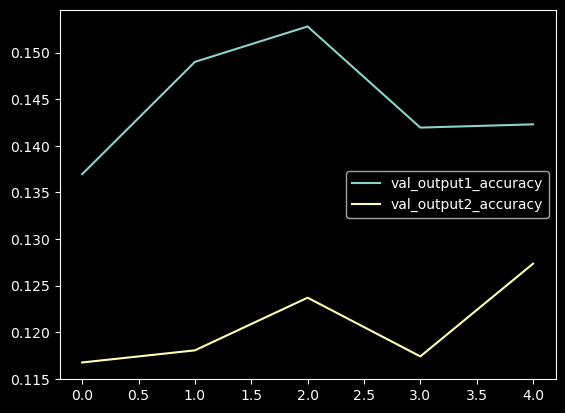

In [67]:
import pandas as pd
pd.DataFrame(result.history)[['val_output1_accuracy','val_output2_accuracy']].plot();

In [ ]:
model.save(Path('saved_temp'))

In [ ]:
from tensorflow.keras.models import load_model

m = load_model(Path('saved_temp'))

In [ ]:
m.evaluate(val_generator)

20/20 [==============================] - 2s 62ms/step - loss: 7.9567 - output1_loss: 5.5393 - output2_loss: 2.4174 - output1_accuracy: 0.1189 - output2_accuracy: 0.1263


[7.956679821014404,
 5.539268970489502,
 2.417412281036377,
 0.11890000104904175,
 0.12630000710487366]